## scVI integration of Xenium and scRNAseq and annotation transfer

In [1]:
import sys 
import os
from datetime import datetime
today = datetime.now().strftime("%Y-%m-%d")
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import hdf5plugin

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Add repo path to sys path (allows to access scripts and metadata from repo)
repo_path = os.path.split(os.getcwd())[0]
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')

%reload_ext autoreload

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100
import matplotlib
from matplotlib import rcParams
#rcParams['pdf.fonttype'] = 42
#sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

In [4]:
# Define plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
model_path = os.path.join(repo_path, 'models')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

# Load data

adata = ad.read_h5ad(f'{general_data_path}/compartmentSplits/thyAgeing_tSplits_allScvi_21-03-2024.zarr')

In [ ]:
xenium_adata = ad.read_h5ad(f'{data_path}/xenium/adata_xenium_2025-01-14.zarr')

xenium_adata.layers['counts'] = xenium_adata.X.copy()

In [9]:
xenium_adata = ad.read_h5ad(f'{data_path}/xenium/adata_xenium_2025-01-14.zarr')

In [11]:
xenium_adata.var.to_csv(f'{data_path}/xenium/xenium_var_names.csv')

In [ ]:
sc.pp.filter_cells(xenium_adata, min_counts = 100)

In [ ]:
obs = pd.read_csv(f'{data_path}/xenium/adata_xenium_scvi_anno_2025-01-18.csv', index_col = 0)

In [ ]:
xenium_adata.obs= obs.reindex(xenium_adata.obs_names).copy()

In [ ]:
xenium_adata.obs['Sample_hr'].value_counts()

In [ ]:
scell_adata = ad.read_h5ad(f'/lustre/scratch126/cellgen/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/data/objects/rna/thyAgeing_all_scvi_v4_2025-02-04.zarr')

scell_obs = pd.read_csv('/lustre/scratch126/cellgen/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/data/objects/rna/thyAgeing_all_scvi_v4_2025-02-04_curatedAnno_v8.csv', index_col = 0)

In [ ]:
scell_obs.columns

In [ ]:
scell_adata.shape
scell_obs.shape

In [19]:
from utils import update_obs, get_latest_version
latest_meta_path = get_latest_version(dir = f'{general_data_path}/metadata', file_prefix='Thymus_ageing_metadata')
latest_meta_path
meta = pd.read_excel(latest_meta_path)
update_obs(scell_adata, meta, update_cols = ['age_months', 'age_group'], on = 'sample')
update_obs(scell_adata, scell_obs, update_cols = ['anno_status', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1',
       'taa_l0'], on = 'taa_l5')

Latest file: Thymus_ageing_metadata_v28_2025-03-13.xlsx


'/lustre/scratch126/cellgen/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/data/metadata/Thymus_ageing_metadata_v28_2025-03-13.xlsx'

Updating columns: ['age_months', 'age_group']
On columns: sample
Updating columns: ['anno_status', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1', 'taa_l0']
On columns: taa_l5


## Concatenate single-cell and Xenium (all)

In [29]:
xenium_adata.var['gene_name'] = xenium_adata.var_names

In [34]:
common_features = np.intersect1d(xenium_adata.var['gene_ids'],scell_adata.var['gene_ids'])

common_features_gnames = np.intersect1d(xenium_adata.var['gene_name'],scell_adata.var['gene_name'])

len(common_features)
len(common_features_gnames)

xenium_adata.var_names = xenium_adata.var['gene_ids']
scell_adata.var_names = scell_adata.var['gene_ids']

4993

4993

In [51]:
scell_adata.obs

,barcode,sample,library,index,library_tcr_ab,library_tcr_gd,library_bcr,path_raw_gex,starsolo_version,path_cellbender_gex,path_cellranger_arc,donor,chemistry_simple,chemistry_detail,chemistry_orig,origin_institute,research_no,study,sort,sort_type,in_HTSA,public_data,type,cite,health_status,age_group,age_group2,age,age_num,age_unit,age_cont,sex,age_months,path_tcr_ab,path_tcr_gd,path_bcr,comment,n_counts,n_genes,percent_mito,percent_ribo,percent_hb,scrublet_score,predicted_doublet,taa_l5,taa_l4,taa_l3,taa_l2,taa_l1,taa_l0,anno_status
TA13072046-ACACCCTTCAGCACAT,ACACCCTTCAGCACAT,A67-THY-0-SC-FACS-3_5GEX,TA13072046,TA13072046,NaN,NaN,NaN,/lustre/scratch126/cellgen/team205/vk8/irods_d...,2.7.4a,/lustre/scratch126/cellgen/team205/vk8/irods_d...,nan,A67,5GEX,10x 5' v2.0,5'v2,CBTM,19/0067,Thymus_ageing,EPCAM+CD205+,FACS,no,no,cells,False,healthy,adult,adult(early),20y,20,y,20,M,240,NaN,NaN,NaN,NaN,154702,9959,0.021331,0.182493,0.000168,0.109278,False,Fb-interlo,Fb-interlo,Fb-interlo,Fb,Fb,Stroma,include
TA13072046-GCATGTACATGTAGTC,GCATGTACATGTAGTC,A67-THY-0-SC-FACS-3_5GEX,TA13072046,TA13072046,NaN,NaN,NaN,/lustre/scratch126/cellgen/team205/vk8/irods_d...,2.7.4a,/lustre/scratch126/cellgen/team205/vk8/irods_d...,nan,A67,5GEX,10x 5' v2.0,5'v2,CBTM,19/0067,Thymus_ageing,EPCAM+CD205+,FACS,no,no,cells,False,healthy,adult,adult(early),20y,20,y,20,M,240,NaN,NaN,NaN,NaN,153258,9290,0.020495,0.205053,0.000072,0.098266,False,Fb-interlo,Fb-interlo,Fb-interlo,Fb,Fb,Stroma,include
TA13072046-CCGGTAGTCAGCTTAG,CCGGTAGTCAGCTTAG,A67-THY-0-SC-FACS-3_5GEX,TA13072046,TA13072046,NaN,NaN,NaN,/lustre/scratch126/cellgen/team205/vk8/irods_d...,2.7.4a,/lustre/scratch126/cellgen/team205/vk8/irods_d...,nan,A67,5GEX,10x 5' v2.0,5'v2,CBTM,19/0067,Thymus_ageing,EPCAM+CD205+,FACS,no,no,cells,False,healthy,adult,adult(early),20y,20,y,20,M,240,NaN,NaN,NaN,NaN,149385,9752,0.025491,0.201633,0.000154,0.121951,False,Fb-interlo,Fb-interlo,Fb-interlo,Fb,Fb,Stroma,include
TA13072046-GGCCGATCAGTCGTGC,GGCCGATCAGTCGTGC,A67-THY-0-SC-FACS-3_5GEX,TA13072046,TA13072046,NaN,NaN,NaN,/lustre/scratch126/cellgen/team205/vk8/irods_d...,2.7.4a,/lustre/scratch126/cellgen/team205/vk8/irods_d...,nan,A67,5GEX,10x 5' v2.0,5'v2,CBTM,19/0067,Thymus_ageing,EPCAM+CD205+,FACS,no,no,cells,False,healthy,adult,adult(early),20y,20,y,20,M,240,NaN,NaN,NaN,NaN,137372,9776,0.032314,0.192936,0.000051,0.103586,False,Fb-interlo,Fb-interlo,Fb-interlo,Fb,Fb,Stroma,include
TA13072046-CGATCGGGTACGCTGC,CGATCGGGTACGCTGC,A67-THY-0-SC-FACS-3_5GEX,TA13072046,TA13072046,NaN,NaN,NaN,/lustre/scratch126/cellgen/team205/vk8/irods_d...,2.7.4a,/lustre/scratch126/cellgen/team205/vk8/irods_d...,nan,A67,5GEX,10x 5' v2.0,5'v2,CBTM,19/0067,Thymus_ageing,EPCAM+CD205+,FACS,no,no,cells,False,healthy,adult,adult(early),20y,20,y,20,M,240,NaN,NaN,NaN,NaN,132976,9073,0.016025,0.216219,0.000045,0.098266,False,Fb-interlo,Fb-interlo,Fb-interlo,Fb,Fb,Stroma,include
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
THY_81-TGTAGACAGCGTTAGG,TGTAGACAGCGTTAGG,THY_81,THY_81_82,THY_81,NaN,NaN,NaN,NaN,NaN,/lustre/scratch126/cellgen/team205/lm25/thymus...,nan,NIHTHY0081,5GEX,NaN,NaN,NIH,NaN,Notarangelo2024,CD45,NaN,NaN,no,cells,True,healthy,infant,infant,7d,7,d,7,M,0,NaN,NaN,NaN,NaN,607,412,0.023064,0.294893,0.001647,0.060870,False,T_αβT(entry),T_αβT(entry),T_αβT(entry),T_dev,T,Lymphoid,include
THY_81-ACCCTCAAGTTGCTCA,ACCCTCAAGTTGCTCA,THY_81,THY_81_82,THY_81,NaN,NaN,NaN,NaN,NaN,/lustre/scratch126/cellgen/team205/lm25/thymus...,nan,NIHTHY0081,5GEX,NaN,NaN,NIH,NaN,Notarangelo2024,CD45,NaN,NaN,no,cells,True,healthy,infant,infant,7d,7,d,7,M,0,NaN,NaN,NaN,NaN,607,411,0.021417,0.265239,0.000000,0.035514,False,T_CD4_naive,T_CD4_naive,T_CD4,T_mature,T,Lymphoid,include
THY_81-CACTGTCCAGGAACCA,CACTGTCCAGGAACCA,THY_81,THY_81_82,THY_81,NaN,NaN,NaN,NaN,NaN,/lustre/scratch126/cellgen/team205/lm25/thymus...,n

In [54]:
xenium_adata.obs.rename(columns = {'Sample':'sample', 'DonorID': 'donor', 'SampleID': 'library', 
                                  'Age(misc)': 'age', 'Sex': 'sex', 'Chemistry_detail': 'chemistry_simple'}, inplace = True)

In [55]:
scell2xen_paed = ad.concat([scell_adata[scell_adata.obs['age_group'].isin(['paed', 'adult']),], xenium_adata], label = 'batch', 
                                                                                         keys = ['scell', 'xenium'])

In [58]:
scvi.model.SCVI.setup_anndata(scell2xen_paed, batch_key='sample',
                                  categorical_covariate_keys=['chemistry_simple', 'batch'],
                                  continuous_covariate_keys=None)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [59]:
vae = scvi.model.SCVI(scell2xen_paed, n_layers = 3, n_latent = 50)

In [63]:
vae.train(batch_size=2000, max_epochs=200, check_val_every_n_epoch = 1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/da

Epoch 200/200: 100%|█| 200/200 [2:54:35<00:00, 52.18s/it, v_num=1, t

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [2:54:35<00:00, 52.38s/it, v_num=1, t


In [ ]:
scell2xen_paed.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(scell2xen_paed, use_rep="X_scVI")

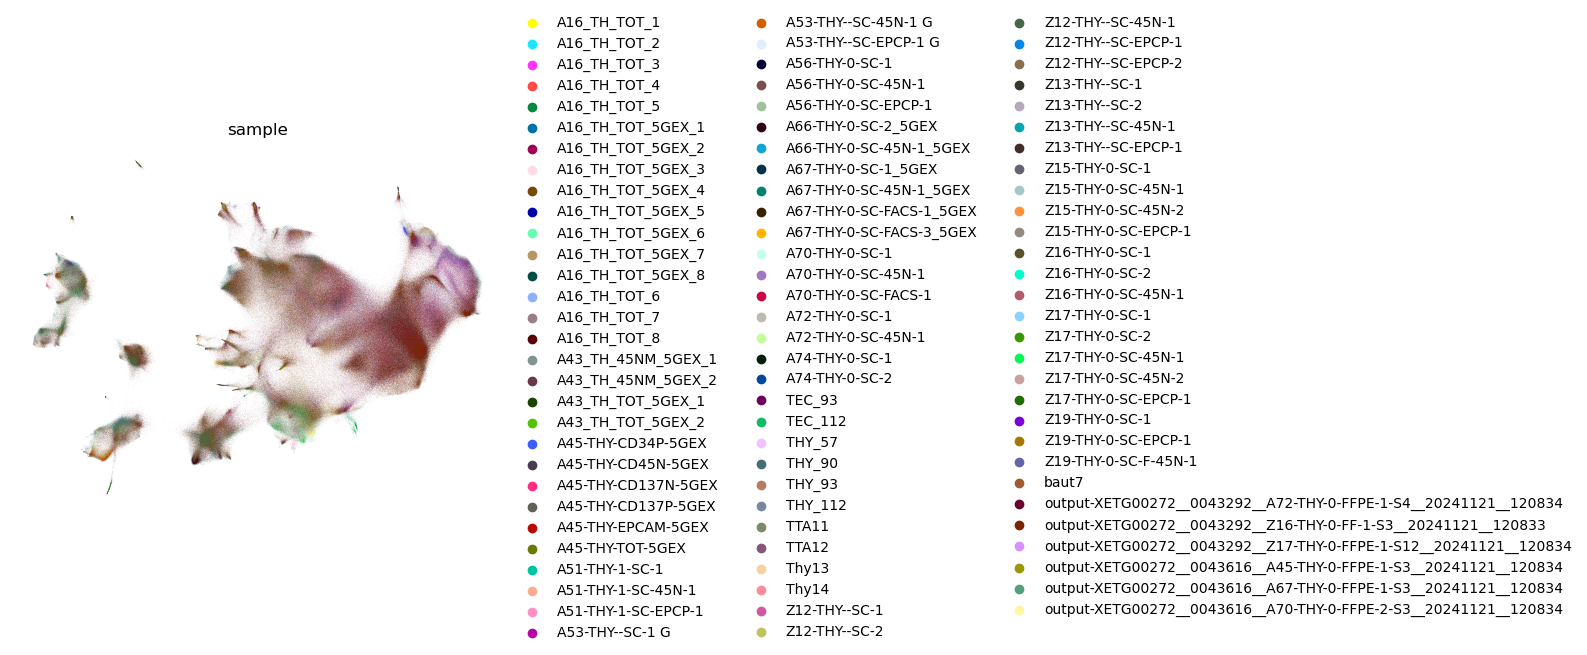

In [65]:
sc.tl.umap(scell2xen_paed, min_dist = 0.1, spread = 1)
sc.pl.umap(scell2xen_paed, color = 'sample', frameon = False)

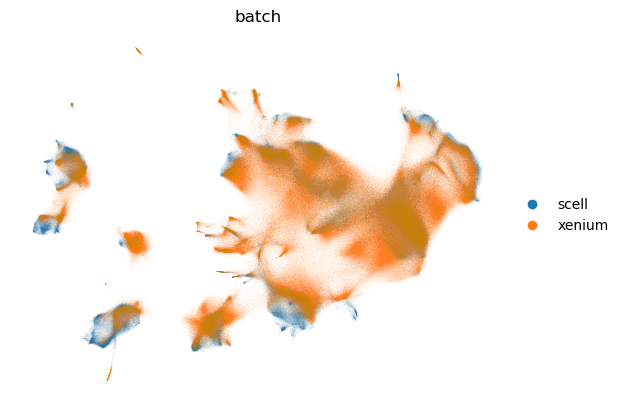

In [66]:
sc.pl.umap(scell2xen_paed, color = 'batch', frameon = False)

In [67]:
scell2xen_paed

AnnData object with n_obs × n_vars = 2353427 × 4993
    obs: 'sample', 'library', 'donor', 'chemistry_simple', 'age', 'sex', 'age_months', 'n_counts', 'taa_l5', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1', 'taa_l0', 'batch', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'sample_colors', 'batch_colors'
    obsm: '_scvi_extra_categorical_covs', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

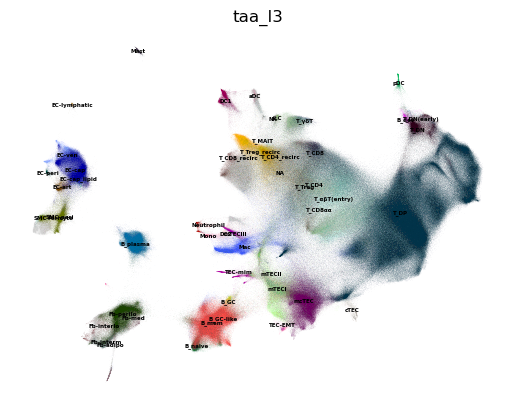

In [69]:
sc.pl.umap(scell2xen_paed, color = 'taa_l3', legend_loc = 'on data', legend_fontsize = 4, frameon = False)

In [70]:
today

'2025-04-04'

In [75]:
scell2xen_paed

AnnData object with n_obs × n_vars = 2353427 × 4993
    obs: 'sample', 'library', 'donor', 'chemistry_simple', 'age', 'sex', 'age_months', 'n_counts', 'taa_l5', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1', 'taa_l0', 'batch', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'sample_colors', 'batch_colors', 'taa_l1_colors', 'taa_l3_colors'
    obsm: '_scvi_extra_categorical_covs', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [81]:
scell2xen_paed.obs['age_months'] = scell2xen_paed.obs['age_months'].astype('int64').copy()

In [82]:
#if not os.path.exists(f'{data_path}/xenium') or overwrite:
#    scvi_run['data'].obs = scvi_run['data'].obs.drop(columns=anno_cols)
scell2xen_paed.write_h5ad(f'{data_path}/xenium/thyAgeing_scell2xenium_{today}.zarr',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options)
vae.save(f'{model_path}/thyAgeing_scell2xenium_{today}.zarr', save_anndata=False, overwrite=True)


## Load the data

In [5]:
scell2xen = ad.read_h5ad(f'{data_path}/xenium/thyAgeing_scell2xenium_2025-04-04.zarr')

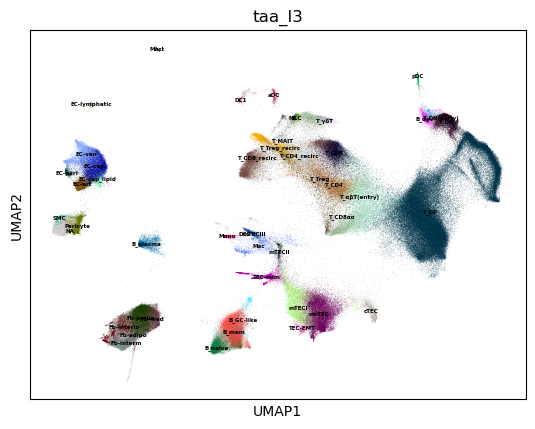

In [7]:
sc.pl.umap(scell2xen[scell2xen.obs['batch'] == 'scell'], color = 'taa_l3', legend_loc = 'on data', legend_fontsize = 4)

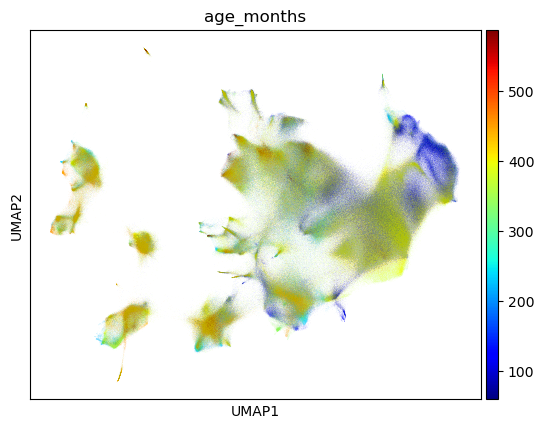

In [8]:
sc.pl.umap(scell2xen, color = 'age_months', cmap = 'jet')

/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


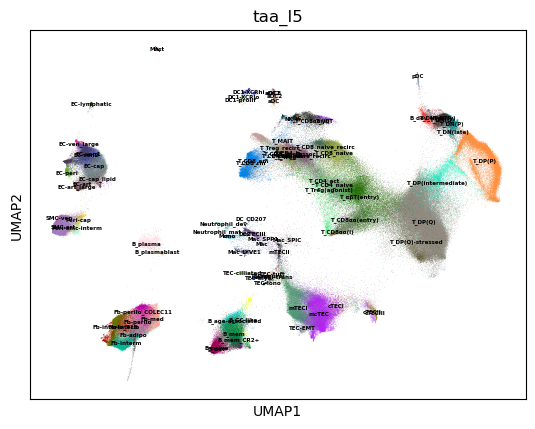

In [9]:
sc.pl.umap(scell2xen[scell2xen.obs['batch'] == 'scell'], color = 'taa_l5', legend_loc = 'on data', legend_fontsize = 4)

In [10]:
scell2xen[(scell2xen.obs['batch'] == 'scell') & (scell2xen.obs['taa_l4'].isnull()),].obs['taa_l5'].value_counts()

taa_l5
SMC-art           13418
Fb-interlo_P16     9689
DC1-XCRhi           418
Neutrophil_dev      208
DC_CD207            174
DC1-XCRlo           131
aDC                 115
Neutrophil_mat       34
Name: count, dtype: int64

In [11]:
scell = scell2xen[(scell2xen.obs['batch'] == 'scell'),].copy()

In [12]:
scell_obs = pd.read_csv('/lustre/scratch126/cellgen/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/data/objects/rna/thyAgeing_all_scvi_v4_2025-02-04_curatedAnno_v10.csv', index_col = 0)

In [13]:
scell.obs[['anno_status', 'taa_l5', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1',
       'taa_l0']] = scell_obs.reindex(scell.obs_names)[['anno_status', 'taa_l5', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1',
       'taa_l0']]

diff_cells = np.setdiff1d(scell.obs_names, scell_obs.index)

In [24]:
sum(scell.obs['taa_l5'].isnull())

1647

In [25]:
scell = scell[~scell.obs['taa_l5'].isnull()].copy()

In [28]:
xenium = scell2xen[scell2xen.obs['batch'] == 'xenium',].copy()

In [1]:
import scanpy as sc
import pandas as pd
import os
import numpy as np
import anndata
from sklearn.neighbors import KNeighborsTransformer

#These functions are taken from scArches package (https://github.com/theislab/scarches)

def weighted_knn_trainer(train_adata, train_adata_emb, n_neighbors=50):
    """Trains a weighted KNN classifier on ``train_adata``.
    Parameters
    ----------
    train_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to train KNN classifier with ``label_key`` as the target variable.
    train_adata_emb: str
        Name of the obsm layer to be used for calculation of neighbors. If set to "X", anndata.X will be
        used
    n_neighbors: int
        Number of nearest neighbors in KNN classifier.
    """
    print(
        f"Weighted KNN with n_neighbors = {n_neighbors} ... ",
        end="",
    )
    k_neighbors_transformer = KNeighborsTransformer(
        n_neighbors=n_neighbors,
        mode="distance",
        algorithm="brute",
        metric="euclidean",
        n_jobs=-1,
    )
    if train_adata_emb == "X":
        train_emb = train_adata.X
    elif train_adata_emb in train_adata.obsm.keys():
        train_emb = train_adata.obsm[train_adata_emb]
    else:
        raise ValueError(
            "train_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    k_neighbors_transformer.fit(train_emb)
    return k_neighbors_transformer    

def weighted_knn_transfer(
    query_adata,
    query_adata_emb,
    ref_adata_obs,
    label_keys,
    knn_model,
    threshold=1,
    pred_unknown=False,
    mode="package",
):
    """Annotates ``query_adata`` cells with an input trained weighted KNN classifier.
    Parameters
    ----------
    query_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to queryate KNN classifier. Embedding to be used
    query_adata_emb: str
        Name of the obsm layer to be used for label transfer. If set to "X",
        query_adata.X will be used
    ref_adata_obs: :class:`pd.DataFrame`
        obs of ref Anndata
    label_keys: str
        Names of the columns to be used as target variables (e.g. cell_type) in ``query_adata``.
    knn_model: :class:`~sklearn.neighbors._graph.KNeighborsTransformer`
        knn model trained on reference adata with weighted_knn_trainer function
    threshold: float
        Threshold of uncertainty used to annotating cells as "Unknown". cells with
        uncertainties higher than this value will be annotated as "Unknown".
        Set to 1 to keep all predictions. This enables one to later on play
        with thresholds.
    pred_unknown: bool
        ``False`` by default. Whether to annotate any cell as "unknown" or not.
        If `False`, ``threshold`` will not be used and each cell will be annotated
        with the label which is the most common in its ``n_neighbors`` nearest cells.
    mode: str
        Has to be one of "paper" or "package". If mode is set to "package",
        uncertainties will be 1 - P(pred_label), otherwise it will be 1 - P(true_label).
    """
    if not type(knn_model) == KNeighborsTransformer:
        raise ValueError(
            "knn_model should be of type sklearn.neighbors._graph.KNeighborsTransformer!"
        )

    if query_adata_emb == "X":
        query_emb = query_adata.X
    elif query_adata_emb in query_adata.obsm.keys():
        query_emb = query_adata.obsm[query_adata_emb]
    else:
        raise ValueError(
            "query_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    top_k_distances, top_k_indices = knn_model.kneighbors(X=query_emb)

    stds = np.std(top_k_distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)

    top_k_distances_tilda = np.exp(-np.true_divide(top_k_distances, stds))

    weights = top_k_distances_tilda / np.sum(
        top_k_distances_tilda, axis=1, keepdims=True
    )
    cols = ref_adata_obs.columns[ref_adata_obs.columns.str.startswith(label_keys)]
    uncertainties = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    pred_labels = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    for i in range(len(weights)):
        for j in cols:
            y_train_labels = ref_adata_obs[j].values
            unique_labels = np.unique(y_train_labels[top_k_indices[i]])
            best_label, best_prob = None, 0.0
            for candidate_label in unique_labels:
                candidate_prob = weights[
                    i, y_train_labels[top_k_indices[i]] == candidate_label
                ].sum()
                if best_prob < candidate_prob:
                    best_prob = candidate_prob
                    best_label = candidate_label

            if pred_unknown:
                if best_prob >= threshold:
                    pred_label = best_label
                else:
                    pred_label = "Unknown"
            else:
                pred_label = best_label

            if mode == "package":
                uncertainties.iloc[i][j] = (max(1 - best_prob, 0))

            else:
                raise Exception("Inquery Mode!")

            pred_labels.iloc[i][j] = (pred_label)

    print("finished!")

    return pred_labels, uncertainties

In [30]:
knn_trainer_scell = weighted_knn_trainer(train_adata = scell, train_adata_emb = 'X_scVI', 
                                         n_neighbors=30)

Weighted KNN with n_neighbors = 30 ... 

In [31]:
predict, uncert = weighted_knn_transfer(
    query_adata = xenium,
    query_adata_emb = 'X_scVI',
    ref_adata_obs = scell.obs,
    label_keys = ('taa_l5', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1', 'taa_l0'),
    knn_model = knn_trainer_scell,
    threshold=1,
    pred_unknown=False,
    mode="package",
)

/tmp/ipykernel_2701986/2539319877.py:130: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  uncertainties.iloc[i][j] = (max(1 - best_prob, 0))
/tmp/ipykernel_2701986/2539319877.py:135: FutureWarning: ChainedAssignmentError: behaviour will change

finished!


In [35]:
predict.columns = [f'knn_pred-{i}' for i in ['taa_l5', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1', 'taa_l0']]
uncert.columns = [f'knn_uncert-{i}' for i in ['taa_l5', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1', 'taa_l0']]    

In [38]:
knn_pred_df = pd.concat([predict, uncert],axis = 1)

In [71]:
knn_pred_df.to_csv(f'{data_path}/xenium/ThyAge_xenium_scarches_annos_{today}.csv')

## Load adata and predictions

In [5]:
scell2xen = ad.read_h5ad(f'{data_path}/xenium/thyAgeing_scell2xenium_2025-04-04.zarr')

xenium_var = pd.read_csv(f'{data_path}/xenium/xenium_var_names.csv', index_col = 0)

xenium_var['gene_name'] = xenium_var.index
xenium_var.index = xenium_var['gene_ids'].copy()

scell2xen.var['gene_name'] = xenium_var.reindex(scell2xen.var_names)['gene_name'].copy()
scell2xen.var['gene_ids'] = scell2xen.var_names
scell2xen.var_names = scell2xen.var['gene_name']
scell2xen.var.index.rename('index', inplace = True)

knn_pred_df = pd.read_csv(f'{data_path}/xenium/ThyAge_xenium_scarches_annos_2025-04-09.csv', index_col = 0)
knn_cols = knn_pred_df.columns.tolist()
scell2xen.obs[knn_cols] = knn_pred_df.reindex(scell2xen.obs_names)

/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attr

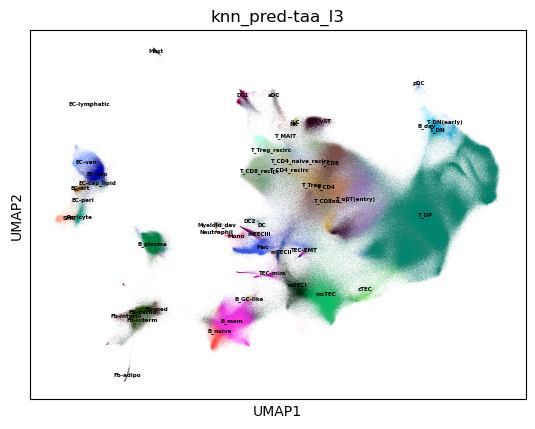

In [10]:
sc.pl.umap(scell2xen[scell2xen.obs['batch'] == 'xenium'], color = 'knn_pred-taa_l3', legend_loc = 'on data', legend_fontsize = 4)

/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attr

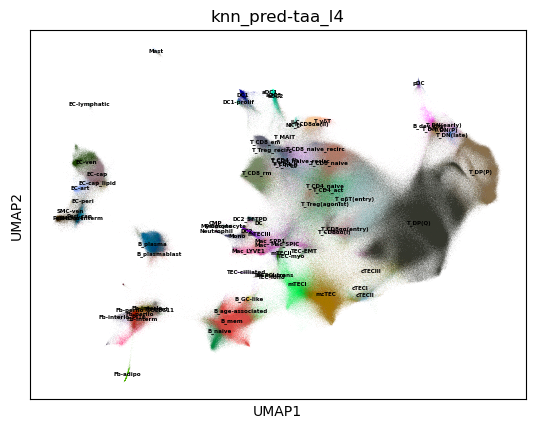

In [48]:
sc.pl.umap(scell2xen[scell2xen.obs['batch'] == 'xenium'], color = 'knn_pred-taa_l4', legend_loc = 'on data', legend_fontsize = 4)

/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attr

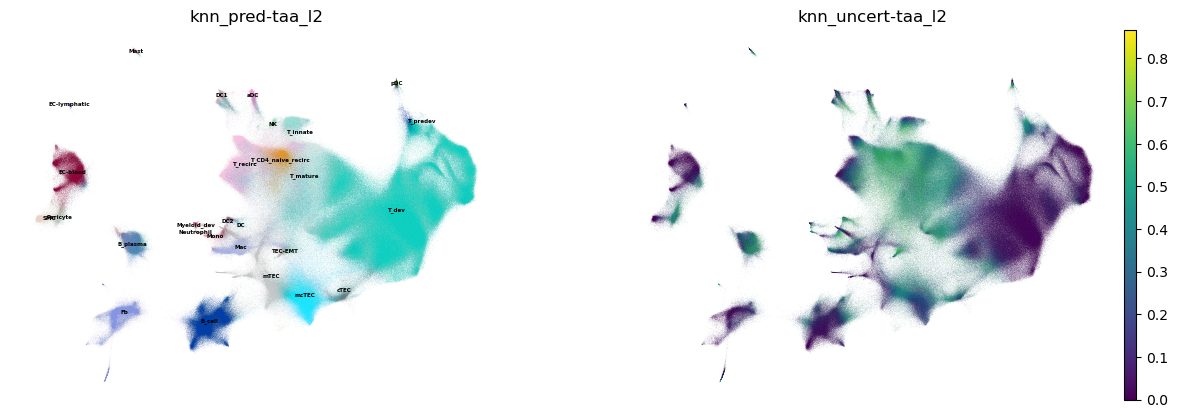

In [50]:
sc.pl.umap(scell2xen[scell2xen.obs['batch'] == 'xenium'], color = ['knn_pred-taa_l2','knn_uncert-taa_l2'], 
           legend_loc = 'on data', legend_fontsize = 4, frameon = False)

/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/vk8/mambaforge/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attr

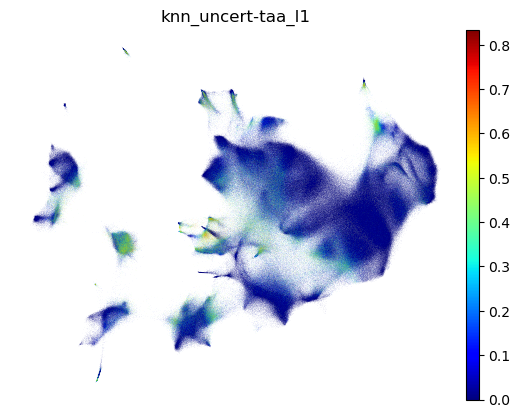

In [58]:
sc.pl.umap(scell2xen[scell2xen.obs['batch'] == 'xenium'], color = ['knn_uncert-taa_l1'], 
           cmap = 'jet', frameon = False)

In [11]:
xenium = scell2xen[scell2xen.obs['batch'] == 'xenium',].copy()

In [87]:
xenium.obs['knn_pred-taa_l1'].value_counts()

knn_pred-taa_l1
T              1269206
TEC             245415
B               163917
EC               65723
Fb               60869
Mac              39460
DC               30214
Mural            22763
Mast              7450
Mono              3980
Myeloid_dev       1410
NK                 593
Neutrophil         340
Name: count, dtype: int64

In [15]:
compartments = {'T_NK': ['T', 'NK'], 
               'B': ['B'], 
               'TEC': ['TEC'], 
               'Stroma': ['EC', 'Fb', 'Pericyte', 'SMC', 'Mural'], 
               'Myeloid': ['Mac', 'Mono', 'DC', 'Myeloid_dev', 'Neutrophil', 'Mast']}

In [16]:
for col in [f'knn_uncert-{i}' for i in ['taa_l5', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1', 'taa_l0']]:
    xenium.obs[col] = xenium.obs[col].astype('float64')

In [17]:
today = '2025-04-09'

In [18]:
for c,ctype in compartments.items():
    adata_c = xenium[xenium.obs['knn_pred-taa_l1'].isin(ctype),].copy()
    adata_c.obs['knn_pred-taa_l1'].value_counts()
    adata_c.write_h5ad(f'{data_path}/xenium/adata_xenium_{c}_{today}.zarr', 
                       compression=hdf5plugin.FILTERS["zstd"],
        compression_opts=hdf5plugin.Zstd(clevel=5).filter_options)
    print(f'{data_path}/xenium/adata_xenium_{c}_{today}.zarr has been written')

knn_pred-taa_l1
T     1269206
NK        593
Name: count, dtype: int64

/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses/data/xenium/adata_xenium_T_NK_2025-04-09.zarr has been written


knn_pred-taa_l1
B    163917
Name: count, dtype: int64

/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses/data/xenium/adata_xenium_B_2025-04-09.zarr has been written


knn_pred-taa_l1
TEC    245415
Name: count, dtype: int64

/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses/data/xenium/adata_xenium_TEC_2025-04-09.zarr has been written


knn_pred-taa_l1
EC       65723
Fb       60869
Mural    22763
Name: count, dtype: int64

/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses/data/xenium/adata_xenium_Stroma_2025-04-09.zarr has been written


knn_pred-taa_l1
Mac            39460
DC             30214
Mast            7450
Mono            3980
Myeloid_dev     1410
Neutrophil       340
Name: count, dtype: int64

/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses/data/xenium/adata_xenium_Myeloid_2025-04-09.zarr has been written
